### Website for plot comparisons:
http://www.astro.utu.fi/~cflynn/galdyn/lecture4.html

# Imports 

In [29]:
import sympy as sp
import numpy as np
from sympy import init_printing
from sympy.abc import rho,sigma,G, pi,phi
import pprint
init_printing() 
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.linewidth'] = 2


# Constants  

In [30]:
G_cgs     = 6.67e-8 # grav constant
k_boltz_cgs   = 1.380649e-16
solar_mass_cgs = 2e33 #grams
solar_temp_cgs = 5778 #Kelvin

# Symbolic math for isothermal/Plummer spheres  density & potentials

## Isothermal Sphere 

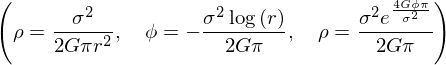

In [31]:
r = sp.symbols('r')
expr_rho = pow(sigma,2) / (2* pi*G*pow(r,2))
rho_eq = sp.Eq(rho, expr_rho)

expr_2   = pow(sigma,2) / ((2* pi*G))
expr_phi = sp.Mul(sp.exp( ( (4 * G * pi ) / (sigma ** 2)) * phi )) * expr_2 
rho_eq_2 = sp.Eq(rho, expr_phi)

rho_first_int = sp.integrate(expr_rho, r)
phi_eq = sp.integrate(rho_first_int, r)
phi_eq = sp.Eq(phi, phi_eq)
rho_eq, phi_eq, rho_eq_2

## Plummer Sphere

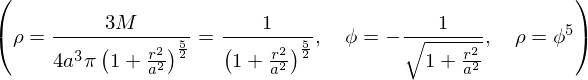

In [32]:
r_plum, a_plum, M_plum = sp.symbols(('r', 'a', 'M'), evaluate=False)
plummer_constants = sp.Mul(3, M_plum, evaluate=False) / \
    sp.Mul(4*pi, pow(a_plum, 3), evaluate=False)
expr_plum = plummer_constants * \
    pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-5/2))
expr_plum2 = pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-5/2))

rho_eq_plum = sp.Eq(rho, expr_plum, evaluate=False)
rho_eq_plum = sp.Eq(rho_eq_plum, expr_plum2, evaluate=False)
# phi_eq_plum = sp.integrate(sp.integrate(rho_eq_plum,r),r)
# phi_eq_plum_int = sp.Eq(phi, phi_eq_plum,evaluate=True)

phi_eq_plum_int = pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-1/2))
phi_eq_plum = sp.Eq(phi, -1*phi_eq_plum_int, evaluate=False)


rho_eq_plum_2 = sp.Eq(rho, phi**5, evaluate=False)

rho_eq_plum, phi_eq_plum, rho_eq_plum_2

# Analytic Functions

In [33]:
# PHI (r) ### ANALYTIC EQ
def phi_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1, _M=1, _geometry="iso"):
    # iso
    if _geometry == "iso":
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        _calc = (((_sigma ** 2.0) * np.log(_r)) / (2.0 * _Grav_const * np.pi))

    # plum
    if _geometry == "plum":
        _calc = (-1*_Grav_const*_M) * \
            (((_r**2.0) + (_a_plum ** 2.0)) ** (-1/2))

    return _calc

# RHO (r) ### ANALYTIC EQ


def rho_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1, _M=1, _geometry="iso"):

    # iso
    if _geometry == "iso":
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        _calc = (_sigma ** 2.0) / (2.0 * _Grav_const * np.pi * (_r**(2.0)))

    # plum
    if _geometry == "plum":
        _calc = (3.0 * _M)/(4.0*np.pi) * \
            pow((1.0+pow((_r/_a_plum), 2.0)), -5/2)

    return _calc

# RHO (phi) ### ANALYTIC EQ


def rho_of_phi_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1,
                        _M=1, _geometry="iso"):

    # iso
    if _geometry == "iso":
        _phi = phi_of_r_analytic(_r, _k_boltz=_k_boltz, _Grav_const=_Grav_const, _mean_mass=_mean_mass,
                                 _temp=_temp, _geometry=_geometry)
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        exp_term = np.exp(((4 * _Grav_const * np.pi * _phi) / (_sigma ** 2.0)))
        _calc = ((_sigma ** 2.0) / (2 * _Grav_const * np.pi)) * exp_term

    # plum
    if _geometry == "plum":
        _phi = phi_of_r_analytic(
            _r, _Grav_const=1, _a_plum=1, _M=1, _geometry=_geometry)
        _calc = np.abs(_phi**5.0)

    return _calc

# r (phi) ### ANALYTIC EQ


def r_of_phi_analytic(_r, _phi_func=phi_of_r_analytic, _k_boltz=1,
                      _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1, _M=1,
                      _geometry="iso"):
    # iso
    if _geometry == "iso":
        _phi = phi_of_r_analytic(_r, _k_boltz=_k_boltz, _Grav_const=_Grav_const, _mean_mass=_mean_mass,
                                 _temp=_temp, _geometry=_geometry)
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        _term = (2 * _Grav_const * np.pi * _phi) / (_sigma ** 2.0)
        _calc = np.exp(_term)

    # plum
    if _geometry == "plum":
        _phi = phi_of_r_analytic(
            _r, _Grav_const=_Grav_const, _a_plum=_a_plum, _M=_M, _geometry="plum")
        _calc = _a_plum*np.sqrt((_phi**-2.0) - 1.0)

    return _calc

# M (r) ### ANALYTIC EQ


def m_of_r_analytic(_r, _phi_func=phi_of_r_analytic, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1,
                    _a_plum=1, _M=1, _geometry="iso"):

    # iso
    if _geometry == "iso":
        _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
        _constants = (2.0 * (_sigma ** 2.0)) / _Grav_const
        _calc = _constants * _r

    # plum
    if _geometry == "plum":
        _calc = ((_r**3.0)*_M) * (((_r**2.0) + (_a_plum ** 2.0)) ** (-3/2))

    return _calc

# Vcirc (r) ### ANALYTIC EQ


def vcirc_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1, _a_plum=1, _M=1,
                        _geometry="iso"):

    _holder = np.zeros(_r.size)

    # iso
    if _geometry == "iso":
        _constants = np.sqrt((_k_boltz * _temp) / (2 * np.pi * _Grav_const))
        _calc = _holder + _constants

    # plum
    if _geometry == "plum":
        _calc = _r * pow((1+pow((_r/_a_plum), 2)), -3/4)

    return _calc

# Numerical Functions

## Derivatives 

In [34]:
# Take derivative of function (an array that is a function of x) W.R.T x
def take_deriv(_x, _y):
    """
    This function takes as input:
    _x = function inputs
    _y = f(function inputs _x)

    Outputs an array with shape (len(_x-1),2);
    containing two arrays: the right bin edges for numerical derivative and numerical derivative(_x)
    """
    _dy_dx = np.diff(_y)/np.diff(_x)
    _x2 = (_x[:-1] + _x[1:]) / 2.0
    return np.array((_x2, _dy_dx))

# Poisson Solver for rho of r -> takes phi_of_r to start


def rho_solver_for_phi_of_r_poisson(_r, _phi_func_array, _deriv_func=take_deriv, _Grav_const=1):
    """
    This function calculates numerical rho(r) from the analytic phi of (r) expression by using the
    poisson equation for spherically symmetric potentials

    This function takes as input:
    _r              = radius array
    _phi_func_array = array containing phi(_r)
    _deriv_func     = calls derivative function defined above
    _Grav_constant  = Gravitational constant set equal to 1 as default

    Outputs an array with shape (len(_r),2);
    containing two arrays: the right bin edges for numerical rho(r) and numerical rho(_r)

    _normalize determines whether or not you want numerical rho to be normalized by the analytic
    expression

    """
    _RHS_constants = (4.0*np.pi*_Grav_const)
    print("_Grav_const is one")
    # make derivative pieces
    _r, _d_phi_dr = _deriv_func(_x=_r, _y=_phi_func_array)

    # start calcs
    _first_term = (_r**2.0) * _d_phi_dr
    _r, _outer_derive = _deriv_func(_x=_r, _y=_first_term)

    # LHS of Poisson EQ
    _LHS = (_r**-2.0) * _outer_derive
    _calc = _LHS / _RHS_constants
    return np.array((_r, _calc))

# POISSON Rho solver for specified geometry


def rho_of_r_poisson_numerical(_r, _phi_func_array, _rho_func_array, _deriv_func=take_deriv, _normalize=False):
    """
    This function calculates numerical rho(r) from the analytic phi of (r) expression by using the
    poisson equation for spherically symmetric potentials

    This function takes as input:
    _r              = radius array
    _phi_func_array = array containing phi(_r)
    _rho_func_array = array containing rho(_r)
    _deriv_func     = calls derivative function defined above

    Outputs an array with shape (len(_r-2),2);
    containing two arrays: the right bin edges for numerical rho(r) and numerical rho(_r)

    _normalize determines whether or not you want numerical rho to be normalized by the analytic
    expression

    """
    _r_output, _calc = rho_solver_for_phi_of_r_poisson(
        _r, _phi_func_array, _deriv_func=_deriv_func)

    if _normalize == True:

        # Normalization Constant
        normalization_constant = _rho_func_array[0] / _calc[0]
#         print (_calc.shape)

        # Normalize and account for infs/nans
        if _r_output.shape[0] < _calc[np.isfinite(_calc)].shape[0]:
            _r_output = _r_output
        else:
            _r_output = _r_output[np.isfinite(_calc)]

        _calc = _calc[np.isfinite(_calc)] * normalization_constant

    return np.array((_r_output, _calc))

## Integrals

In [35]:
def trap_function(_input_array, _function_array):
    """
    This function calculates the trapozoidal integral approximation of function_array accross the 
    entire function range

    This function takes as input:
    _input_array    = function inputs
    _function_array = f(function inputs _x) 

    Outputs an array with shape (len(_input_array-1),2);
    containing two arrays: the right bin edges for numerical integral and numerical integral of _function_array
    """
    # number of points
    _N = len(_function_array)
    # def dx
    _a, _b = min(_input_array), max(_input_array)
    # holding bins
    integral_result = np.zeros(len(_function_array)-1)
    x_values = np.zeros(len(_function_array)-1)
    # hard code first preset value
    previous_value = 0

    for ii in range(1, len(_function_array)):
        # get endpoints
        _f = _function_array[ii-1:ii+1]
        # store x value corresponding to right endpoint
        _x = _input_array[ii-1:ii+1]
        # grab the spacing
        _dx = np.diff(_x)
        # def endpoint
        _f_right = _f[1:]  # right endpoint
        _f_left = _f[:-1]  # left endpoint
        # integrate
        integral_result[ii-1] = ((_dx/2.0) *
                                 np.sum(_f_right + _f_left))+previous_value
        # store previous value for summation
        previous_value = integral_result[ii-1]
        # save x values using right bin edge
        x_values[ii-1] = _x[1:]

    return np.array((x_values, integral_result))


def phi_solver_of_rho(_r, _analytic_rho, _analytic_phi, _int_function=trap_function, _Grav_const=1,
                      _normalize=True):
    """
    This function calculates the numerical phi(r) by using the poisson equation for spherically
    symmetric potentials

    This function takes as input:
    _r            = radius array
    _analytic_rho = array containing analytic rho(_r)
    _analytic_phi = array containing analytic phi(_r)
    _int_function = trapazoidal integral function defined above
    _Grav_const   =1

    Outputs an array with shape (len(_r-1),2);
    containing two arrays: the right bin edges for numerical integral and numerical integral of _function_array

    _normalize determines whether or not you want numerical phi to be normalized by the analytic
    expression
    """
    # poisson
    _constants = 4.0*np.pi*_Grav_const
    print("_Grav_const is one")

    # integration stuff

    # get the integral
    _r, _first_term = _int_function(
        _input_array=_r, _function_array=_analytic_rho*_r**2.0)

    # get the second_integral
    _r, _second_term = _int_function(
        _input_array=_r, _function_array=_first_term/(_r**2.0))

    _calc = _second_term*_constants

    if _normalize == True:

        # Normalization Constant
        _normalization_constant = (_analytic_phi[-1] / _calc[-1])

        _calc = _calc * _normalization_constant
        _calc = _calc - (_calc[-1]-_analytic_phi[-1])

    return np.array((_r, _calc))

## Input Array 

In [36]:
_N = 100000
# r_array_2_iso = np.linspace(0.1, 100, _N)  # 0 to 40
r_array_2_iso = np.logspace(-1,2,_N) # 0.1 to 100

# Isothermal Sphere

## Variables for plotting

In [18]:
# Top Row
_geometry = "iso"

# Phi of r
r_iso, phi_of_r_analytic_iso = r_array_2_iso, phi_of_r_analytic(
    r_array_2_iso, _geometry=_geometry)


# rho of r
r_iso, rho_of_r_analytic_iso = r_array_2_iso, rho_of_r_analytic(
    r_array_2_iso, _geometry=_geometry)

# rho of r and derivatives
# Poisson normalized
r_iso_poisson_normalized, dphi2_dr2_grad_poisson_normalized = rho_of_r_poisson_numerical(
    _r=r_iso, _phi_func_array=phi_of_r_analytic_iso,_rho_func_array=rho_of_r_analytic_iso,
    _deriv_func=take_deriv, _normalize=True)


# r of phi 
r_of_phi_iso, rho_of_r_of_phi_iso = r_of_phi_analytic(
    r_array_2_iso), rho_of_r_analytic(_r=r_of_phi_analytic(r_array_2_iso, _geometry=_geometry))

# phi of r numerical

_phi_of_r_x_vals, phi_of_r_numerical = phi_solver_of_rho(_r=r_iso, _analytic_rho=rho_of_r_analytic_iso,
                                                         _analytic_phi=phi_of_r_analytic_iso,
                                                         _int_function=trap_function, _normalize=True)

# rho(r) analytic -> phi(r) numerical -> rho(r) numerical
# logspace
r_iso_poisson_normalized_test, dphi2_dr2_grad_poisson_normalized_test = rho_of_r_poisson_numerical(
    _phi_of_r_x_vals, _phi_func_array=phi_of_r_numerical, _rho_func_array=rho_of_r_analytic_iso,
    _deriv_func=take_deriv, _normalize=True)

# r_first_deriv, drho_dr  = take_deriv(rho_of_r_analytic(r_array_2_iso,_geometry=_geometry),_x=r_array_2_iso,_n=1)

# # second derivative`
# r_second_derive, d2rho_dr2  = take_deriv(rho_of_r_analytic(r_array_2_iso,_geometry=_geometry),_x=r_array_2_iso,_n=2)

_Grav_const is one
_Grav_const is one
_Grav_const is one


## Plots

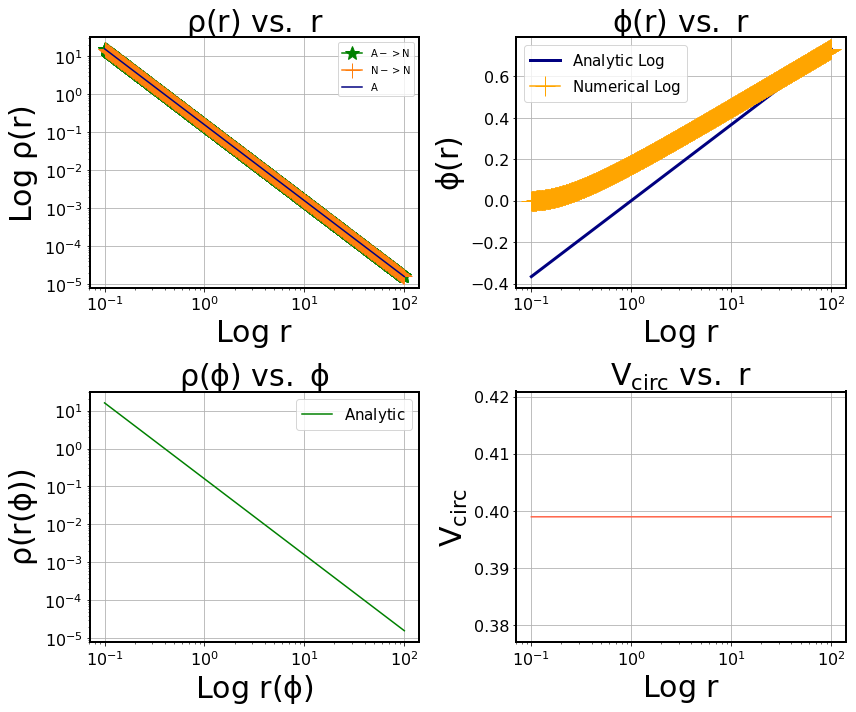

In [19]:
# create figure object
fig = plt.figure(1)
fig.set_figheight(10)
fig.set_figwidth(12)

# create axis object
ax = plt.subplot(221)
plt.grid(True)

# ploting

plt.plot(r_iso_poisson_normalized, dphi2_dr2_grad_poisson_normalized,
         'green',marker="*",markersize=15,markevery=100, label=r'$\mathrm{A -> N}$')
plt.plot(r_iso_poisson_normalized_test, dphi2_dr2_grad_poisson_normalized_test, 'tab:orange',marker="+"
         ,markersize=15,markevery=200, label=r'$\mathrm{N -> N}$')
plt.plot(r_iso, rho_of_r_analytic_iso, 'navy', label=r'$\mathrm{A}$')
# plt.plot(rho_of_r_diff, drho_dr_diff,'r*',label=r'$\mathrm{np.diff}$')


# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()


# create axis space
ax = plt.subplot(222)
plt.grid(True)

# ploting
##ploting
plt.plot(r_array_2_iso, phi_of_r_analytic_iso,color='navy',linewidth=3,label=r'$\mathrm{Analytic\ Log}$')
plt.plot(_phi_of_r_x_vals,phi_of_r_numerical,marker="+",color="orange",markersize=20,markevery=100,label=r'$\mathrm{Numerical\ Log}$')

# labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()


# create axis space
ax = plt.subplot(223)
plt.grid(True)

# ploting
# plt.plot(phi_iso_sphere_of_r_analytic_py(r_array_2),rho_iso_sphere_of_phi_analytic_py(r_array_2),
#          color='tomato',label=r'$\mathrm{Analytic}$')
plt.plot(r_of_phi_iso, rho_of_r_of_phi_iso,
         color='green', label=r'$\mathrm{Analytic}$')

# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

# labeling
plt.title(r'$\mathrm{\rho(\phi)\ vs.\ \phi}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r(\phi)}$', size=30)
plt.ylabel(r'$\mathrm{\rho (r(\phi))}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# create axis space
ax = plt.subplot(224)
plt.grid(True)

# ploting
plt.plot(r_array_2_iso, vcirc_of_r_analytic(r_array_2_iso,_geometry=_geometry), color='tomato')

# labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
plt.tight_layout()

## isothermal Sphere: Density vs potential and it's derivatives

In [20]:
# fig = plt.figure(3)
# fig.set_figheight(6)
# fig.set_figwidth(15)

# #create axis object
# ax = plt.subplot(131)
# plt.grid(True)

# ##ploting
# plt.plot(r_iso, rho_of_r_analytic,
#          label=r'$\mathrm{Analytic}$')

# #labeling
# # plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
# plt.xlabel(r'$\mathrm{Log\ \phi (r)}$',size=30)
# plt.ylabel(r'$\mathrm{Log\ \rho(r) }$',size=30)

# ax.tick_params(axis='x', which='major', labelsize=16)
# ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
# plt.semilogx()
# plt.legend(fontsize=15)
# plt.tight_layout()

# #create axis object
# ax = plt.subplot(132)
# plt.grid(True)

# ##ploting
# plt.plot(-drho_dr,rho_of_r_analytic,label=r'$\mathrm{numerical}$')

# #labeling
# # plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
# plt.xlabel(r'$\mathrm{Log\ -\frac{\mathrm{d} \phi(r)}{\mathrm{d}r}}$',size=30)
# plt.ylabel(r'$\mathrm{Log\ \rho(r) }$',size=30)
# ax.tick_params(axis='x', which='major', labelsize=16)
# ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
# plt.semilogx()
# plt.legend(fontsize=13)
# plt.tight_layout()

# ax = plt.subplot(133)
# plt.grid(True)


# ##ploting
# plt.plot(d2rho_dr2, rho_of_r_analytic,label=r'$\mathrm{numerical}$')

# #labeling
# # plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
# plt.xlabel(r'$\mathrm{\frac{\mathrm{d}^2 \phi}{\mathrm{d}r^2}}$',size=30)
# plt.ylabel(r'$\mathrm{\rho(r) }$',size=30)
# ax.tick_params(axis='x', which='major', labelsize=16)
# ax.tick_params(axis='y', which='major', labelsize=16)
# # plt.semilogy()
# # plt.semilogx()
# plt.legend(fontsize=15)
# plt.tight_layout()

# # plt.xlabel(r'$\mathrm{\frac{\mathrm{d}^2 \omega}{\mathrm{d}\theta^2}}$',size=30)

# Plummer Sphere

## Inputs

In [21]:
_N = 100000
r_array_2_plum = np.logspace(-1,2,_N) # 0.1 to 100

## Variables for plotting 

In [22]:
# Top Row
_geometry = "plum"

# Phi of r
r_plum, phi_of_r_analytic_plum = r_array_2_plum, phi_of_r_analytic(
    r_array_2_plum, _geometry=_geometry)


# rho of r
r_plum, rho_of_r_analytic_plum = r_array_2_plum, rho_of_r_analytic(
    r_array_2_plum, _geometry=_geometry)

# rho of r and derivatives
# Poisson normalized
r_plum_poisson_normalized, dphi2_dr2_grad_poisson_normalized = rho_of_r_poisson_numerical(
    _r=r_plum, _phi_func_array=phi_of_r_analytic_plum,_rho_func_array=rho_of_r_analytic_plum,
    _deriv_func=take_deriv, _normalize=True)


# r of phi 
r_of_phi_plum, rho_of_r_of_phi_plum = r_of_phi_analytic(
    r_array_2_plum), rho_of_r_analytic(_r=r_of_phi_analytic(r_array_2_plum, _geometry=_geometry))

# phi of r numerical

_phi_of_r_x_vals, phi_of_r_numerical = phi_solver_of_rho(_r=r_plum, _analytic_rho=rho_of_r_analytic_plum,
                                                         _analytic_phi=phi_of_r_analytic_plum,
                                                         _int_function=trap_function, _normalize=False)

# rho(r) analytic -> phi(r) numerical -> rho(r) numerical
# logspace
r_plum_poisson_normalized_test, dphi2_dr2_grad_poisson_normalized_test = rho_of_r_poisson_numerical(
    _phi_of_r_x_vals, _phi_func_array=phi_of_r_numerical, _rho_func_array=rho_of_r_analytic_plum,
    _deriv_func=take_deriv, _normalize=True)


# r_first_deriv, drho_dr  = take_deriv(rho_of_r_analytic(r_array_2_plum,_geometry=_geometry),_x=r_array_2_plum,_n=1)

# # second derivative`
# r_second_derive, d2rho_dr2  = take_deriv(rho_of_r_analytic(r_array_2_plum,_geometry=_geometry),_x=r_array_2_plum,_n=2)

_Grav_const is one
_Grav_const is one
_Grav_const is one


## Plots 

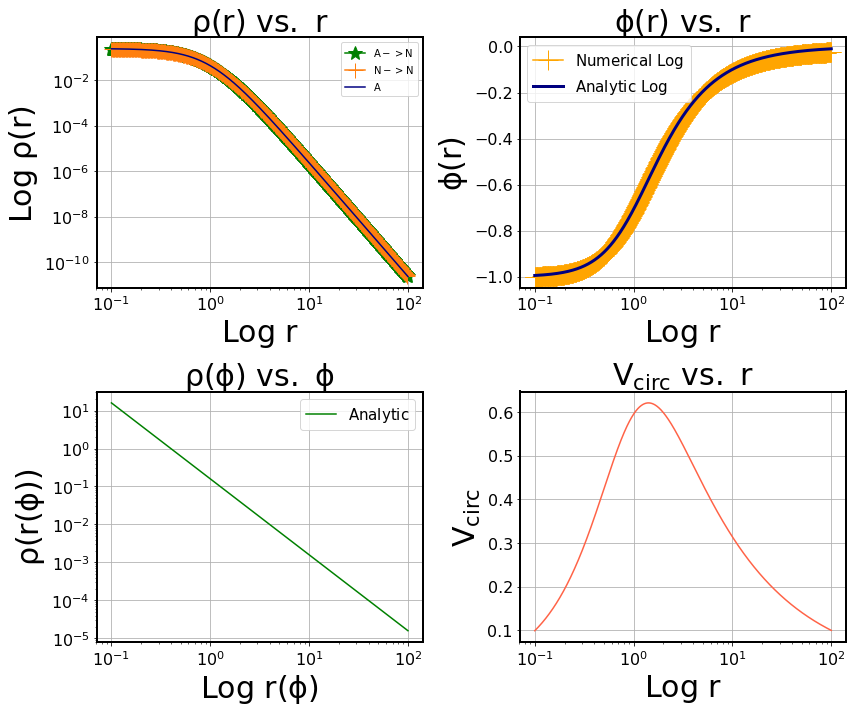

In [23]:
# create figure object
fig = plt.figure(2)
fig.set_figheight(10)
fig.set_figwidth(12)

# create axis object
ax = plt.subplot(221)
plt.grid(True)

# ploting

plt.plot(r_plum_poisson_normalized, dphi2_dr2_grad_poisson_normalized,
         'green',marker="*",markersize=15,markevery=100, label=r'$\mathrm{A -> N}$')
plt.plot(r_plum_poisson_normalized_test, dphi2_dr2_grad_poisson_normalized_test, 'tab:orange',marker="+"
         ,markersize=15,markevery=200, label=r'$\mathrm{N -> N}$')
plt.plot(r_plum, rho_of_r_analytic_plum, 'navy', label=r'$\mathrm{A}$')
# plt.plot(rho_of_r_diff, drho_dr_diff,'r*',label=r'$\mathrm{np.diff}$')


# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()


# create axis space
ax = plt.subplot(222)
plt.grid(True)

# ploting
##ploting
plt.plot(_phi_of_r_x_vals,phi_of_r_numerical-1,marker="+",color="orange",markersize=20,markevery=100,label=r'$\mathrm{Numerical\ Log}$')
plt.plot(r_array_2_plum, phi_of_r_analytic_plum,color='navy',linewidth=3,label=r'$\mathrm{Analytic\ Log}$')

# labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()


# create axis space
ax = plt.subplot(223)
plt.grid(True)

# ploting
# plt.plot(phi_plum_sphere_of_r_analytic_py(r_array_2),rho_plum_sphere_of_phi_analytic_py(r_array_2),
#          color='tomato',label=r'$\mathrm{Analytic}$')
plt.plot(r_of_phi_plum, rho_of_r_of_phi_plum,
         color='green', label=r'$\mathrm{Analytic}$')

# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

# labeling
plt.title(r'$\mathrm{\rho(\phi)\ vs.\ \phi}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r(\phi)}$', size=30)
plt.ylabel(r'$\mathrm{\rho (r(\phi))}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# create axis space
ax = plt.subplot(224)
plt.grid(True)

# ploting
plt.plot(r_array_2_plum, vcirc_of_r_analytic(r_array_2_plum,_geometry=_geometry), color='tomato')

# labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
plt.tight_layout()

In [24]:
def cumu_trap_function(_func, _anti_func, _a, _b, _N, _coordinates="cartesian",
                  _number=1):

    # create intervals
    _x = np.linspace(_a, _b, _N+1)  # N intervals

    # def dx
    _dx = (_b - _a)/_N


    _result = np.zeros(len(_x))
    if _coordinates == "spherical_polar":
        for ii in range(1,len(_x)):
        # call func interval, stars with a[1] to a[2]
            _f = _func(_x[ii-1:ii+1])*(_x[ii-1:ii+1]**2.0)

            # integrate over interval
            _result[ii] = (4.0*np.pi*(_dx/2.0)) * np.sum(_f[1:] + _f[:-1])
            
        if _number == 2:
            second_integral = np.zeros(len(_x))
            _f = _func(_x[ii-1:ii+1])*(_x[ii-1:ii+1]**2.0)
            

    if _coordinates == "cartesian":
        for ii in range(1,len(_x)):
            _f = _func(_x)

            # call func interval, stars with a[1] to a[2]
            _f = _func(_x[ii-1:ii+1])

            # integrate over interval
            _result[ii] = (_dx/2.0) * np.sum(_f[1:] + _f[:-1])
            
        if _number == 2:
            second_integral = np.zeros(len(_x))
            _f = _func(_x[ii-1:ii+1])*(_x[ii-1:ii+1]**2.0)
  
    return _result



## Dehnen Density Models

In [37]:
def rho_dehnen(_r,_p0=1,_a=1,_alpha=1,_beta=3):
    #default is NFW
    _term_a = (_r/_a)**_alpha
    _term_b = (1.0 + (_r/_a)) ** (_beta-_alpha)
    _calc = _p0 /(_term_a*_term_b)
    return _calc

def NFW_potential(_r,_p0=1,_a=1,_Grav_constant=1):
    _constants = -4.0*np.pi*_Grav_constant*_p0*(_a**2.0)
    _fraction  = np.log(1.0 + (_r/_a)) / (_r/_a)
    _calc = _constants * _fraction
    return _calc
    
            

## NFW Profile


## Variables for plotting 

In [26]:
_N = 100000
r_array_2_NFW = np.logspace(-1,5,_N) # 0.1 to 1e5

In [27]:
# Rho of r
r_NFW, rho_of_r_analytic_NFW = r_array_2_NFW, rho_dehnen(
    _r=r_array_2_NFW, _p0=1, _a=1, _alpha=1, _beta=3)

#phi of r analytic

phi_of_r_analytic_NFW = NFW_potential(_r=r_array_2_NFW,_p0=1,_a=1,_Grav_constant=1)

# phi of r numerical

_phi_of_r_x_vals_NFW, phi_of_r_numerical_NFW = phi_solver_of_rho(_r=r_array_2_NFW, _analytic_rho=rho_of_r_analytic_NFW,
                                                                 _analytic_phi=phi_of_r_analytic_NFW,
                                                                 _int_function=trap_function, _normalize=False)
#fix phi of r numerical
adjust = max(phi_of_r_numerical_NFW)-max(phi_of_r_analytic_NFW)

phi_of_r_numerical_NFW = phi_of_r_numerical_NFW - adjust
# Rho of R numerical
x_val_NFW, numerical_rho_of_r_NFW = rho_of_r_poisson_numerical(
    _r=r_array_2_NFW, _phi_func_array=phi_of_r_analytic_NFW, _rho_func_array=rho_of_r_analytic_NFW,
    _deriv_func=take_deriv, _normalize=True)

# Rho of R numerical from phi_of_r numerical
x_val_NFW_NN, numerical_rho_of_r_NFW_NN = rho_of_r_poisson_numerical(
    _r=_phi_of_r_x_vals_NFW, _phi_func_array=phi_of_r_numerical_NFW, _rho_func_array=rho_of_r_analytic_NFW,
    _deriv_func=take_deriv, _normalize=True)


#circular velocity numerical

_vcirc_of_r_x_vals_NFW, vcirc_of_r_numerical_NFW = take_deriv(_x= _phi_of_r_x_vals_NFW,
                                                              _y=phi_of_r_numerical_NFW)

vcirc_of_r_numerical_NFW = np.sqrt(_vcirc_of_r_x_vals_NFW * np.abs(vcirc_of_r_numerical_NFW))



_Grav_const is one
_Grav_const is one
_Grav_const is one


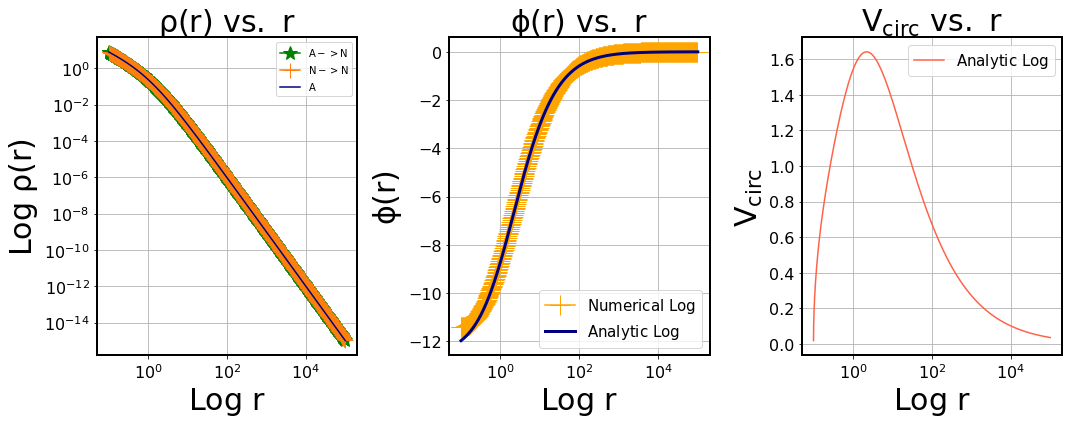

In [28]:
fig = plt.figure(3)
fig.set_figheight(6)
fig.set_figwidth(15)

# create axis object
ax = plt.subplot(131)
plt.grid(True)

# ploting

plt.plot(x_val_NFW, numerical_rho_of_r_NFW,'green',marker="*",markersize=15,markevery=200,
         label=r'$\mathrm{A -> N}$')
plt.plot(x_val_NFW_NN, numerical_rho_of_r_NFW_NN, 'tab:orange',marker="+",markersize=15,
         markevery=200, label=r'$\mathrm{N -> N}$')
plt.plot(r_NFW, rho_of_r_analytic_NFW, 'navy', label=r'$\mathrm{A}$')

# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()

# create axis space
ax = plt.subplot(132)
plt.grid(True)

# ploting
##ploting
plt.plot(_phi_of_r_x_vals_NFW, phi_of_r_numerical_NFW,marker="+",color="orange",markersize=20,markevery=200,label=r'$\mathrm{Numerical\ Log}$')
plt.plot(r_NFW, phi_of_r_analytic_NFW,color='navy',linewidth=3,label=r'$\mathrm{Analytic\ Log}$')

# labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# create axis space
ax = plt.subplot(133)
plt.grid(True)

# ploting
plt.plot(_vcirc_of_r_x_vals_NFW, vcirc_of_r_numerical_NFW, color='tomato',label=r'$\mathrm{Analytic\ Log}$')

# labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()